In [36]:
import sys
from pydmc import *
import scipy.special as spec

q0 = 0.8253525490491695
a0 = 1
nconf = 50
time_step = 1e-2
reference_energy = 3.67603
blocks = 100
steps_per_block = 100
# number of equilibration blocks
neq = 10
hamiltonian = lambda psi, x: -0.5*psi.laplacian(x)
da = 1e-3


def mathieu_modcem1(m, q, x):
    return spec.mathieu_modcem1(m, q, x)

def mathieu_cem(m, q, x):
    # Angular mathieu function in scipy takes input
    # in degrees
    return spec.mathieu_cem(m, q, x*180/np.pi)

def ground_state(mu, nu):
    return mathieu_modcem1(0, q0, mu)[0]*mathieu_cem(0, q0, nu)[0]

class GuidingWaveFunction(WaveFunction, GeometryParametrized):

    def __init__(self, a):
        self._a = a

    def __call__(self, x):
        x, y = x
        #alpha = self._a[0]*np.cosh(1)
        #beta = self._a[0]*np.sinh(1)
        #r = np.sqrt((x/alpha)**2 + (y/beta)**2)
        #return (r + 1)/2 * (1 - (r+1)/2)
        mu = np.real(np.arccosh((x + 1j*y)/self._a[0]))
        nu = np.imag(np.arccosh((x + 1j*y)/self._a[0]))
        return x*ground_state(mu, nu)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

    def geometry_parameters(self):
        return self._a

    def deform(self, parameter_change):
        return GuidingWaveFunction(self._a + parameter_change)


def dmc(da, vcut=True):
    brancher = SRBrancher()
    ar = DiffuseAcceptReject(fixed_node=True)

    guiding_wf = GuidingWaveFunction(np.array([a0]))

    np.random.seed(0)
    confs = [np.random.uniform(low=-1, high=1, size=2) for _ in range(nconf)]
    walkers = [Walker(conf, 1.0) for conf in confs]

    fas = [
        ForcesExactAndVD(np.array([da]), nconf, cutoff=cutoff)    
    ]

    if vcut:
        vcutoff = velocity_cutoff_umrigar
    else:
        vcutoff = lambda v, tau: v
    
    dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy, 
              force_accumulators=fas, velocity_cutoff=vcutoff)
    dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

    return dmc


def compute_forces(fa):
    errs = []
    bs = list(range(2, blocks-neq+1, (blocks-neq+1)//20))
    for b in bs:
        nconf = b * steps_per_block
        flhf, flpulay, fhf, fpulay, w = fa.compute_forces(steps_per_block, nconf)
        f = fhf + fpulay
        fl = flhf + flpulay
        f_err = block_error(fl[0, :], block_size=steps_per_block)
        errs.append(f_err)

    return flhf, flpulay, w

In [37]:
res_cut = dmc(da)
res_nocut = dmc(da, vcut=False)

100%|██████████| 100/100 [26:12<00:00, 15.72s/it]


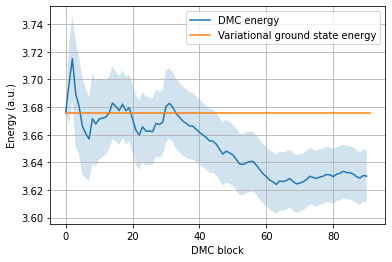

In [5]:
plt.figure()
ns = np.arange(0, len(res_cut.energy_estimate))
plt.plot(ns, res_cut.energy_estimate, label="DMC energy")
plt.fill_between(ns, res_cut.energy_estimate - res_cut.energy_error, 
                     res_cut.energy_estimate + res_cut.energy_error, alpha=0.2)

plt.plot([0, len(res_cut.energy_estimate)], 
        [reference_energy, reference_energy], label="Variational ground state energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (a.u.)")
plt.grid()

In [30]:
bs = steps_per_block

flhf_cut, flhf_warp_cut, flpulay_exact_cut, flpulay_exact_warp_cut, flpulay_vd_cut, flpulay_vd_warp_cut \
    = res_cut.force_accumulators[0].compute_forces(steps_per_block, steps_per_block*(nconf-neq))[:6]

flhf_nocut, flhf_warp_nocut, flpulay_exact_nocut, flpulay_exact_warp_nocut, flpulay_vd_nocut, flpulay_vd_warp_nocut \
    = res_nocut.force_accumulators[0].compute_forces(steps_per_block, steps_per_block*(nconf-neq))[:6]    

## Hellmann-Feynman

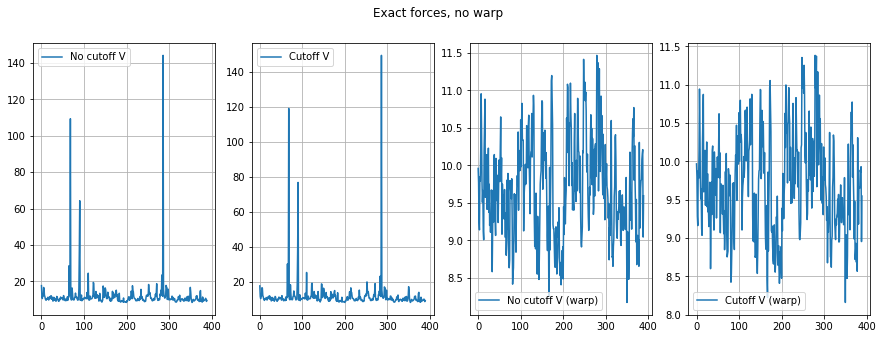

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5), sharey=False)
fig.suptitle("Exact forces, no warp")
axes[0].plot(bin_samples(flhf_nocut[0, :], bs), label="No cutoff V")
axes[1].plot(bin_samples(flhf_cut[0, :], bs), label="Cutoff V")
axes[2].plot(bin_samples(flhf_warp_nocut[0, :], bs), label="No cutoff V (warp)")
axes[3].plot(bin_samples(flhf_warp_cut[0, :], bs), label="Cutoff V (warp)")
for ax in axes: ax.legend(); ax.grid()

#fig.savefig("exact_nowarp.eps")
plt.show()

## Exact Pulay

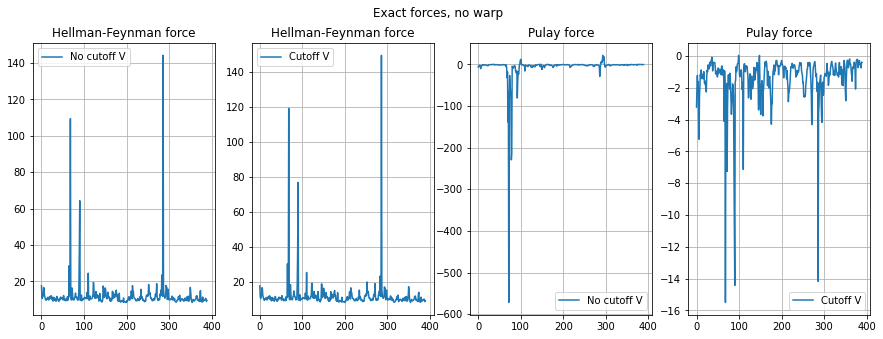

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5), sharey=False)
fig.suptitle("Exact forces, no warp")
axes[0].plot(bin_samples(flhf_nocut[0, :], bs), label="No cutoff V")
axes[1].plot(bin_samples(flhf_cut[0, :], bs), label="Cutoff V")
axes[2].plot(bin_samples(flpulay_exact_nocut[0, :], bs), label="No cutoff V")
axes[3].plot(bin_samples(flpulay_exact_cut[0, :], bs), label="Cutoff V")
for ax in axes[0:2]: ax.set_title("Hellman-Feynman force"); ax.legend(); ax.grid()
for ax in axes[2:]: ax.set_title("Pulay force"); ax.legend(); ax.grid()

plt.show()

## VD Pulay

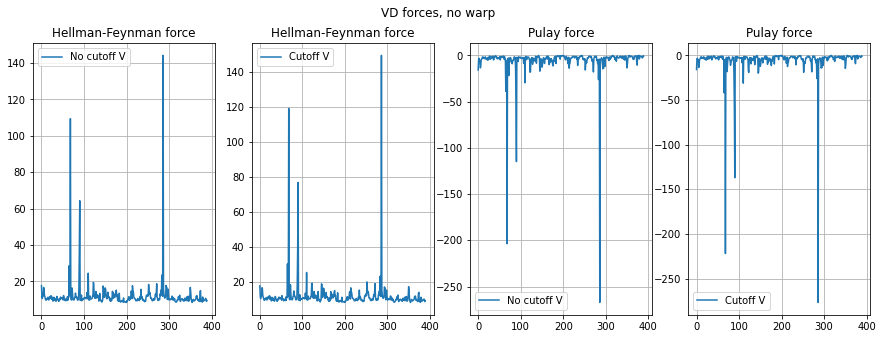

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5), sharey=False)
fig.suptitle("VD forces, no warp")
axes[0].plot(bin_samples(flhf_nocut[0, :], bs), label="No cutoff V")
axes[1].plot(bin_samples(flhf_cut[0, :], bs), label="Cutoff V")
axes[2].plot(bin_samples(flpulay_vd_nocut[0, :], bs), label="No cutoff V")
axes[3].plot(bin_samples(flpulay_vd_cut[0, :], bs), label="Cutoff V")
for ax in axes[0:2]: ax.set_title("Hellman-Feynman force"); ax.legend(); ax.grid()
for ax in axes[2:]: ax.set_title("Pulay force"); ax.legend(); ax.grid()

plt.show()

## HF force comparison

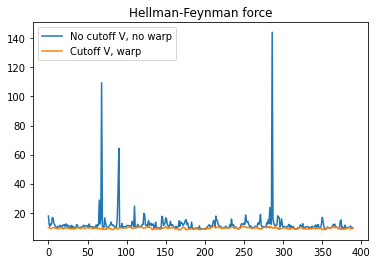

In [15]:
bs = 1

plt.figure()
plt.plot(bin_samples(flhf_nocut[0, :], bs), label="No cutoff V, no warp")
plt.plot(bin_samples(flhf_warp_cut[0, :], bs), label="Cutoff V, warp")
plt.title("Hellman-Feynman force")
#plt.savefig("HF_cutoff_warp.eps")
plt.legend();

## Exact: combining best approaches

For the exact force, the HF force is accurately computed by using the warp transformation, while the Pulay force is noisy. Hence, we only use the node warp transform in the HF force.

In [16]:
flhf_exact_warp, _, fhf_exact_warp = res_cut.force_accumulators[1].compute_forces(steps_per_block, (blocks-neq)*steps_per_block)[:3]
flpulay_exact_nowarp, _, fpulay_exact_nowarp,  = res_cut.force_accumulators[0].compute_forces(steps_per_block, (blocks-neq)*steps_per_block)[1:4]

# error computation
fhf_err = block_error(flhf_exact_warp[0, :], steps_per_block)
fpulay_err = block_error(flpulay_exact_nowarp[0, :], steps_per_block)

err = math.sqrt(fhf_err**2 + fpulay_err**2)

print(f"Force: {fhf_exact_warp[0] + fpulay_exact_nowarp[0]:.5f} +/- {err:.5f}")

IndexError: list index out of range

## VD: best approach

In the VD case, the node warp transform helps both the HF and Pulay forces.

In [46]:
flhf_exact_warp, _, fhf_exact_warp = res_cut.force_accumulators[3].compute_forces(steps_per_block, (blocks-neq)*steps_per_block)[:3]
flpulay_exact_nowarp, _, fpulay_exact_nowarp,  = res_cut.force_accumulators[3].compute_forces(steps_per_block, (blocks-neq)*steps_per_block)[1:4]

# error computation
fhf_err = block_error(flhf_exact_warp[0, :], steps_per_block)
fpulay_err = block_error(flpulay_exact_nowarp[0, :], steps_per_block)

err = math.sqrt(fhf_err**2 + fpulay_err**2)

print(f"Force: {fhf_exact_warp[0] + fpulay_exact_nowarp[0]:.5f} +/- {err:.5f}")

Force: 7.49668 +/- 0.17744
